## Deconstruct a basic pipeline

In [1]:
from diffusers import DDPMScheduler, UNet2DModel
import torch
from PIL import Image
import numpy as np

In [5]:
# Load the model and scheduler
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", sample_size=1024, ignore_mismatched_sizes=True).to(device)
print(model.config.sample_size)

1024


In [6]:
# Set the number of timesteps to run the denoising process for
scheduler.set_timesteps(50)

Setting the scheduler timesteps creates a tensor with evenly spaced elements in it, 50 in this example. Each element corresponds to a timestep at which the model denoises an image. When you create the denoising loop later, you’ll iterate over this tensor to denoise an image

In [7]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [9]:
# Create some random noise with the same shape as the desired output
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to(device)

Now write a loop to iterate over the timesteps. At each timestep, the model does a UNet2DModel.forward() pass and returns the noisy residual. The scheduler’s step() method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it’ll repeat until it reaches the end of the timesteps array.

In [10]:
# Loop to iterate over the timesteps
my_input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(my_input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, my_input).prev_sample
    my_input = previous_noisy_sample

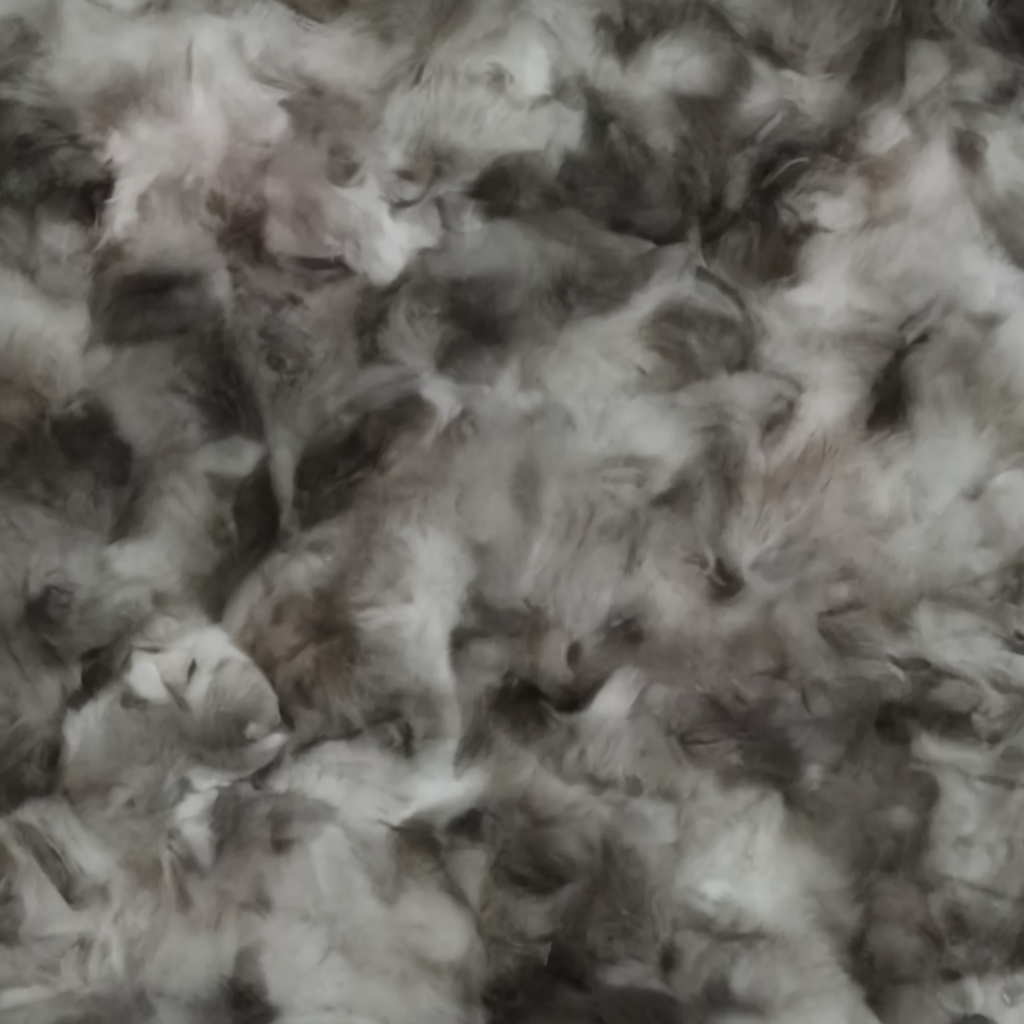

In [11]:
# convert the denoised output into an image
image = (my_input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image